# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes XX de XX de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:


1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?

**R**: La distribución de Poisson es una distribución de probabilidad discreta que expresa la probabilidad de que ocurra un número dado de eventos en un intervalo de tiempo o espacio. Estos eventos ocurren con una tasa media constante conocida e independientemente del tiempo transcurrido desde el último evento. Además las ocurrencias  de los eventos deben ser aleatorias y no contener ningún factor que favorezca unas ocurrencias en favor de otra.

La distribución de Poisson también se puede utilizar para el número de eventos en otros intervalos especificados, tales como la distancia, el área o el volumen. 

La variación de la distribución en función de $\lambda$ está dada por la siguiente figura:



In [3]:
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from math import e

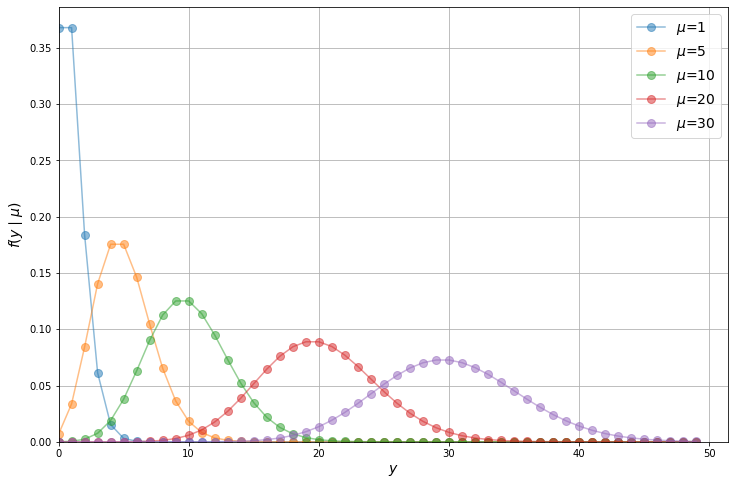

In [4]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * np.exp(-μ)
y_values = range(0, 50)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10, 20, 30]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

Cuando lambda es pequeño la distribución crece para su valor medio, esto significa que a menor valor de lambda es mayor la probabilidad de que los eventos se cumplan la cantidad **media** de veces.

Sin embargo cuando lambda toma valores grandes la distribución toma valores pequeños respecto a su media (y menor para el resto), es decir, la probabilidad de que se cumplan los eventos una cantidad **media** es menor y esta decrece a medida que la cantidad de eventos se aleja del valor medio.

2. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida

Primero reemplazamos:
$$
\begin{align}
p\left ( y_{i}|x_{i} \right ) &= \frac{\lambda_{i}^{y_{i}}\cdot e^{^{-\lambda_{i}}}}{y_{i}!} \\
\\
\lambda _{i} &= e^{\left ( \theta _{0} + \sum_{j=1}^{M} \theta _{j}\cdot X_{ij} \right )} \\
\\
p\left ( y_{i}|x_{i} \right ) &= \frac{\left (e^{\left ( \theta _{0} + \sum_{j=1}^{M} \theta _{j}\cdot X_{ij} \right )} \right)^{y_{i}}\cdot e^{-e^{\left ( \theta _{0} + \sum_{j=1}^{M} \theta _{j}\cdot X_{ij} \right )} }}{y_{i}!}\\
&=\frac{e^{y_{i}\cdot {\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)} - e^{{\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)}}}}{y_{i}!}
\end{align}
$$
Ahora obtenemos una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. : 
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log p(y_i | x_i)\\
&= \sum_{i=1}^N \log p(y_i | x_i)\\
&= \sum_{i=1}^N \log{\frac{e^{y_{i}\cdot {\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)} - e^{{\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)}}}}{y_{i}!}}
\end{align}
$$
Quitamos el logaritmo:
$$
\sum_{i=1}^N {\left ( y_{i}\cdot {\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)} - e^{{\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)}}\right )} - \sum_{i=1}^N \log{(y_{i}!)}
$$
Ahora obtenemos la derivada:

$$
\\
\frac{\partial}{\partial{\theta}} = \sum_{i=1}^N{\left ( y_{i}\cdot(1+\sum_{j=1}^M{x_{ij}}) \right )} - \sum_{i=1}^N{\left ( e^{(\theta_{0} + \sum_{j=1}^M \theta_{j}\cdot x_{ij})}\cdot(1+\sum_{j=1}^M{x_{ij}}) \right )}
$$


## Implementación (1.5pt)

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)
1. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize` 
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación


In [5]:
datos = pd.read_csv("billonarios.csv")

In [6]:
datos.head(5)

,pais,nbillonarios,logpibpc,logpob,gatt
0,United States,469,10.786021,19.532846,60
1,Canada,25,10.743365,17.319439,0
2,"Bahamas, The",0,10.072139,12.760934,0
3,Aruba,0,10.223734,11.526276,0
4,Bermuda,0,11.446847,11.086334,0


In [7]:
datos.isnull().sum()

pais            0
nbillonarios    0
logpibpc        0
logpob          0
gatt            0
dtype: int64

**R1:**
La función de máxima verosimilitud está dada por lo siguiente:

$$
\hat \theta = \text{arg}\max_\theta{\left ( \sum_{i=1}^N {\left ( y_{i}\cdot {\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)} - e^{{\left (\theta_{0} + \sum_{i=1}^N  \theta_{j} \cdot x_{ij}\right)}}\right )} - \sum_{i=1}^N \log{(y_{i}!)}\right ) }
$$

In [8]:
x = datos[['logpibpc', 'logpob', 'gatt']].to_numpy()
y = datos[['nbillonarios']].to_numpy()

In [22]:
import math
import scipy
#sum log(y!)
sum_log_y=0

for i in y:
    sum_log_y = sum_log_y + np.sum(np.log([j for j in range(1,i[0]+1)]))

print(sum_log_y)

3897.6317141977843


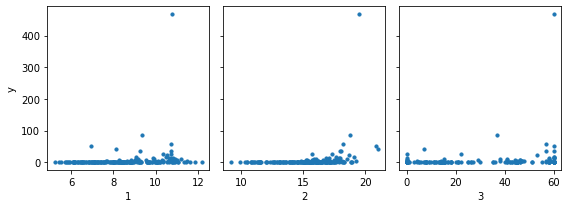

In [142]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True, sharey=True)
for i in range(3):
    ax[i].scatter(x[:,i], y[:,0], s=10)
    ax[i].set_xlabel(i+1)
ax[0].set_ylabel("y");

**R2: Vector de parámetros óptimo**

In [24]:
from scipy.optimize import minimize 
import scipy.stats

def logL(theta_0,theta_1,theta_2,theta_3):
    n1=np.dot(x,[theta_1,theta_2,theta_3])+theta_0
    n2=np.exp(n1)
    return -1*(np.dot(y.T,n1)-np.sum(n2))

def dflogL(theta_0,theta_1,theta_2,theta_3):
    n1 = np.sum(x, axis=1)+theta_0
    n2 = np.exp(np.dot(x,[theta_1,theta_2,theta_3])+theta_0)
    return -1*(np.dot(y.T,n1) - np.dot(n2,n1))

def f(z):
    return (logL(z[0],z[1],z[2],z[3]))

def df(z):
    return (dflogL(z[0],z[1],z[2],z[3]))

def jac_logL(theta_0,theta_1,theta_2,theta_3):
    jac_theta_val = [np.sum(y)-np.sum(np.exp(np.dot(x,[theta_1,theta_2,theta_3])+theta_0)),
                 (np.dot(y.T,x[0:,0])-np.dot(np.exp(np.dot(x,[theta_1,theta_2,theta_3])+theta_0),x[0:,0]))[0],
                 (np.dot(y.T,x[0:,1])-np.dot(np.exp(np.dot(x,[theta_1,theta_2,theta_3])+theta_0),x[0:,1]))[0],
                 (np.dot(y.T,x[0:,2])-np.dot(np.exp(np.dot(x,[theta_1,theta_2,theta_3])+theta_0),x[0:,2]))[0]]
    return jac_theta_val

the = np.random.randn(4)*0.1  
res = scipy.optimize.minimize(fun =f, x0 = the, jac = 'none')
print(the,res.x,res.fun,res.message)
best_theta_val = [res.x[0],res.x[1],res.x[2],res.x[3]]

[-0.13656051 -0.05048505 -0.12854892 -0.06358183] [-2.90495023e+01  1.08385503e+00  1.17136094e+00  5.96774929e-03] -3459.0919420704013 Desired error not necessarily achieved due to precision loss.


**R3: Pseudo Coeficiente de Correlación**

In [25]:
#logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro 𝜃0


def logLtheta0(theta_best_0):
    n1=np.dot(x,[0,0,0])+theta_best_0
    n2=np.exp(n1)
    return -1*(np.dot(y.T,n1)-np.sum(n2))

def ftheta0(z):
    theta_best_0 = z[0]
    return logLtheta0(theta_best_0)

the = np.random.randn(1)*0.1
res = scipy.optimize.minimize(fun =ftheta0, x0 = the) 
print(the,res.x,res.fun,res.message)
best_theta0_val= res.x[0]

[-0.03897743] [1.73609291] -822.9518901243484 Optimization terminated successfully.


In [33]:

f_log_L_best = -logL(best_theta_val[0],best_theta_val[1],best_theta_val[2],best_theta_val[3]) - sum_log_y
f_log_Ltheta0_best = logLtheta0(best_theta0_val) - sum_log_y


In [34]:
#Pseudo Coeficiente de Correlación
def PCC(f_log_L_best,f_log_Ltheta0_best):
    return ((f_log_Ltheta0_best - f_log_L_best)/(f_log_Ltheta0_best))[0] #[0,1]

print(PCC(f_log_L_best,f_log_Ltheta0_best))

0.9071005178838779


In [35]:
y_estim = np.exp(np.dot(x,best_theta_val[1 :])+best_theta_val[0])
MSE = lambda real, estimation : np.mean(np.power(real - estimation, 2))
MSE(y, y_estim)

1986.5547893199596

**R4: Bootstrap Resampling**

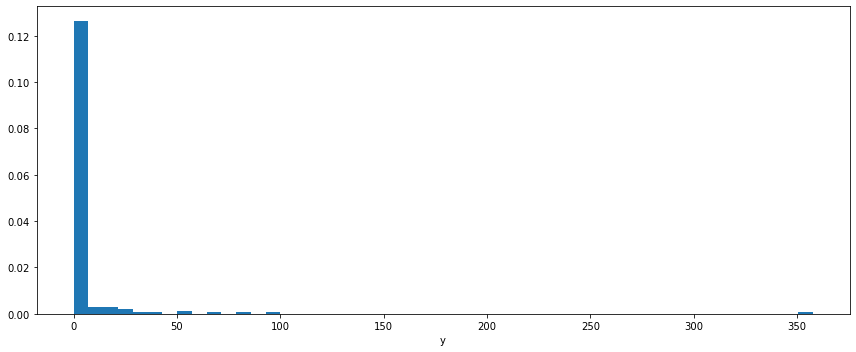

In [68]:
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)
ax.hist(y_estim, bins=50, density=True)
ax.set_xlabel('y');

In [109]:
def muestreo_con_reemplazo(x, y):
    N = len(x)
    idx = np.random.choice(N, size=N, replace=True)
    return x[idx], y[idx]

def boostrap_linregress(x, y, T=100):
    # Parámetros: t0, t1 y r
    params = np.zeros(shape=(T, 3)) 
    for t in range(T):
        res = scipy.stats.linregress(*muestreo_con_reemplazo(x, y))
        params[t, :] = [res.intercept, res.slope, res.rvalue]
    return params

Nuestros theta_i =  [-29.04950228676256, 1.0838550346755416, 1.1713609406708438, 0.005967749288952133]

Intervalo de confianza al 95% de theta_ 1 [0.13238275 0.32922013]

Intervalo de confianza al 95% de theta_ 2 [0.21397705 0.48026395]

Intervalo de confianza al 95% de theta_ 3 [0.13795321 0.35128126]


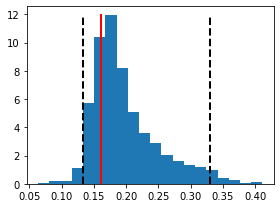

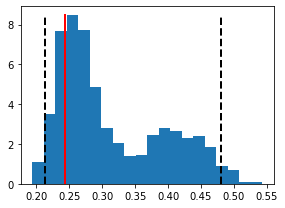

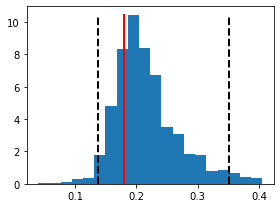

In [121]:
print("Nuestros theta_i = ",best_theta_val)
for i in range(3):    
    a=x[:,i]
    b=y[:,0]
    params = scipy.stats.linregress(a,b)
    boostrap_params = boostrap_linregress(a,b , T=1000)
    r_bootstrap = boostrap_params[:, 2]
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
    hist_val, hist_lim, _ = ax.hist(r_bootstrap, bins=20, density=True)
    ax.plot([params.rvalue]*2, [0, np.max(hist_val)], 'r-', lw=2)
    IC = np.percentile(r_bootstrap, [2.5, 97.5])
    ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    print()
    print(f"Intervalo de confianza al 95% de theta_",i+1,IC)


In [47]:
df = datos
def muestreo_con_reemplazo(df):
    N = len(df)
    idx = np.random.choice(N, size=N, replace=True)
    return df.iloc[idx,:]

def boostrap_find_thetas(df, T=100):
    # Parámetros: t0, t1 y r
    params = np.zeros(shape=(T, 5)) 
    for t in range(T):
    #res = scipy.stats.linregress(*muestreo_con_reemplazo(df))
        the = np.random.randn(4)*0.1
        res = scipy.optimize.minimize(fun =f, x0 = the)
        params[t, :] = [res.intercept, res.slope, res.rvalue]
    return params

boostrap_params = boostrap_find_thetas(df, T=1000)



AttributeError: intercept

In [2]:
r_bootstrap = boostrap_params[:, 2]

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
hist_val, hist_lim, _ = ax.hist(r_bootstrap, bins=20, density=True)

ax.plot([params.rvalue]*2, [0, np.max(hist_val)], 'r-', lw=2)
IC = np.percentile(r_bootstrap, [2.5, 97.5])
ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)

print(f"Intervalo de confianza al 95% de r: {IC}")

NameError: name 'boostrap_params' is not defined

## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 